In [1]:
import os
import sys
import pandas as pd
import copy
import geopandas as gpd
import matplotlib.pyplot as plt
import operator
from IPython.display import Markdown, display, HTML
from tabulate import tabulate
from shapely import geometry, wkt
from shapely.ops import nearest_points
import gridmap_config as c

In [2]:
polygons = c.kenya_counties_msSimplified
os.path.isfile(polygons)

True

In [3]:
admin_polys = gpd.read_file(polygons).to_crs({'init': 'epsg:{}'.format(c.epsg)})
admin_polys = admin_polys.sort_values(by=[c.admin_id]).reset_index(drop=True)
admin_polys = admin_polys.rename(columns={admin_polys.geometry.name: c.geom_col}).set_geometry(c.geom_col)

num_features = admin_polys.shape[0]

tbl_data = [['Fields']]
for fld in list(admin_polys):
        tbl_data.append([fld])
        
display(HTML(tabulate(tbl_data, headers="firstrow", tablefmt='html', stralign='left')))

Fields
County
CID
CountyID
AreaSQKM
Shape_Leng
Shape_Area
Pop_Sumcou
Pop_Sumsum
area
avg_area


In [4]:
def pprint_dict(d):
    print('\n')
    for k, v in d.items():
        print('\t{} : {}'.format(k, v))
        
def describe_gdf(gdf):
    print('TYPE:  {}'.format(type(gdf)))
    print('SHAPE: {}'.format(gdf.shape))
    
def polys_to_centroids(polys):
    # copy poly to new GeoDataFrame
    points = polys.copy()
    # change the geometry
    points.geometry = points[c.geom_col].centroid
    # same crs
    points.crs = polys.crs
    
    return points
    
def display_point_labels(gdf, label_col, fs=10, c='blue'):
    texts = []
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[label_col]):
        texts.append(plt.text(x, y, label, fontsize=fs, color=c))
        
def dissolve_features(features):
    features['dissolve'] = 1
    features_dissolved_gpd = features.dissolve(by='dissolve').to_crs({'init': 'epsg:{}'.format(c.epsg)})
    features_dissolved_polygon = features_dissolved_gpd.geometry[1] # Convert gpd to Shapely Polygon

    return features_dissolved_polygon, features_dissolved_gpd

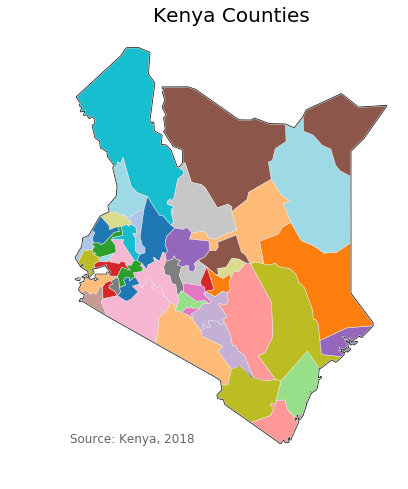

In [5]:
outline_poly, outline_gpd = dissolve_features(admin_polys)

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.axis('off')
ax.set_title('Kenya Counties', fontdict={'fontsize': '20', 'fontweight' : '500'})
ax.annotate('Source: Kenya, 2018',
            xy=(0.17, .115),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='0.4')

outline_gpd.plot(color='white', ax=ax, linewidth=2, edgecolor='0.1')
admin_polys.plot(column=c.symbology_column, cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
plt.show()

In [6]:
def calculate_tile_size(coords):
    square_size = round(min(coords['range_x'],coords['range_y'])/
                        (num_features/c.num_shape_divisor),
                        c.round_to)
    return square_size

def round_coords_dict(coords, r=c.round_to):
    for key, coord in coords.items():
        coords[key] = float(round(coords[key], r))
    
    return coords

def get_bounding_coordinates(feature, round_nums=True):
    coords = feature.bounds 
    bbox = {}
    bbox['min_x'] = coords['minx'].min()
    bbox['min_y'] = coords['miny'].min()
    bbox['max_x'] = coords['maxx'].max()
    bbox['max_y'] = coords['maxy'].max()
    bbox['range_x'] = bbox['max_x'] - bbox['min_x']
    bbox['range_y'] = bbox['max_y'] - bbox['min_y']
    
    if round_nums:
        bbox = round_coords_dict(bbox)
    
    return bbox

def build_extent_polygon(features):
    coords = get_bounding_coordinates(features)
    coords_LL = [coords['min_x'], coords['min_y']]
    coords_LR = [coords['max_x'], coords['min_y']]
    coords_UR = [coords['max_x'], coords['max_y']] 
    coords_UL = [coords['min_x'], coords['max_y']]

    map_ext_polygon = geometry.Polygon([coords_LL,
                                        coords_LR,
                                        coords_UR,
                                        coords_UL])
    map_ext_gdf = gpd.GeoDataFrame(pd.DataFrame({c.geom_col: [map_ext_polygon]}), geometry=c.geom_col)
    
    return coords, map_ext_polygon, map_ext_gdf
    
def seed_box(bb, size, idx, corner='lowerleft'):
    if corner == 'lowerleft':
        LL = [bb['min_x'], bb['min_y']]               #lower left corner
        LR = [bb['min_x'] + size, bb['min_y']]        #lower right corner
        UR = [bb['min_x'] + size, bb['min_y'] + size] #upper right corner
        UL = [bb['min_x'], bb['min_y'] + size]        #upper left corner
    
    if corner == 'lowerright':
        LL = [bb['max_x'] - size, bb['min_y']]        #lower left corner
        LR = [bb['max_x'], bb['min_y']]               #lower right corner
        UR = [bb['max_x'], bb['min_y'] + size] #upper right corner
        UL = [bb['max_x'] - size, bb['min_y'] + size] #upper left corner
        
    if corner == 'upperright':
        LL = [bb['max_x'] - size, bb['max_y'] - size] #lower left corner
        LR = [bb['max_x'], bb['max_y'] - size]        #lower right corner
        UR = [bb['max_x'], bb['max_y']]               #upper right corner
        UL = [bb['max_x'] - size, bb['max_y']]        #upper left corner 
        
    if corner == 'upperleft':
        LL = [bb['min_x'], bb['max_y'] - size]        #lower left corner
        LR = [bb['min_x'] + size, bb['max_y'] - size] #lower right corner
        UR = [bb['min_x'] + size, bb['max_y']]        #upper right corner
        UL = [bb['min_x'], bb['max_y']]               #upper left corner
    
    whys = {'min_y': LL[1], 'max_y': UR[1]}
    to_poly = geometry.Polygon([LL, LR, UR, UL])
    center = to_poly.centroid
    box = gpd.GeoDataFrame(pd.DataFrame({c.geom_col: [to_poly]}), geometry=c.geom_col)
    box[c.tile_id] = idx #Create index column, for later ID
    seed_coords = {'LL': LL, 'LR': LR, 'UR': UR, 'UL': UL}
    
    return box, center, whys, idx

Tile size: 113233.9652007327


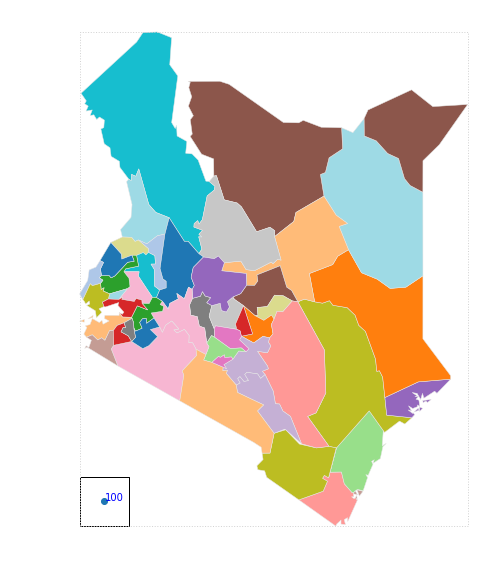

In [7]:
map_extent_coords, map_extent_poly, map_extent_gdf = build_extent_polygon(admin_polys)

tile_size = calculate_tile_size(map_extent_coords)
print('Tile size: {}'.format(tile_size))

seed, centroid, x_coords, tile_idx = seed_box(bb=map_extent_coords, size=tile_size, idx=100, corner=c.seed_location)
seed_center = polys_to_centroids(seed)

# Plot things
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
admin_polys.plot(column=c.symbology_column, cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
seed.plot(ax=ax, facecolor="none", edgecolor='black')
map_extent_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
seed_center.plot(ax=ax)
display_point_labels(seed_center, c.tile_id)

plt.show()

seed = None
centroid = None
x_coords = None

In [8]:
def grow_another_box(seed_box, idx, size=tile_size, corner='lowerleft'):
    bb = get_bounding_coordinates(seed_box, round_nums=False) 

    if corner == 'lowerleft':
        LL = [bb['max_x'], bb['min_y']]               #lower left corner
        LR = [bb['max_x'] + size, bb['min_y']]        #lower right corner
        UR = [bb['max_x'] + size, bb['min_y'] + size] #upper right corner
        UL = [bb['max_x'], bb['min_y'] + size]        #upper left corner
        
    if corner == 'lowerright':
        LL = [bb['min_x'] - size, bb['min_y']]        #lower left corner
        LR = [bb['min_x'], bb['min_y']]               #lower right corner
        UR = [bb['min_x'], bb['min_y'] + size] #upper right corner
        UL = [bb['min_x'] - size, bb['min_y'] + size] #upper left corner

    if corner == 'upperright':
        LL = [bb['min_x'] - size, bb['max_y'] - size] #lower left corner
        LR = [bb['min_x'], bb['max_y'] - size]        #lower right corner
        UR = [bb['min_x'], bb['max_y']]               #upper right corner
        UL = [bb['min_x'] - size, bb['max_y']]        #upper left corner 
        
    if corner == 'upperleft':
        LL = [bb['max_x'], bb['max_y'] - size]        #lower left corner
        LR = [bb['max_x'] + size, bb['max_y'] - size] #lower right corner
        UR = [bb['max_x'] + size, bb['max_y']]        #upper right corner
        UL = [bb['max_x'], bb['max_y']]               #upper left corner
    
    to_poly = geometry.Polygon([LL, LR, UR, UL])
    center = to_poly.centroid
    box_coords = pd.DataFrame({c.geom_col: [to_poly]})
    box = gpd.GeoDataFrame(box_coords, geometry=c.geom_col)
    ns_idx = idx + 1
    box[c.tile_id] = ns_idx #Create index column, for later ID

    return box, center, bb, ns_idx

def tile_center_in_feature(feat, center):
    if type(feat)==geometry.MultiPolygon:
        for f in feat:
            if f.contains(center):
                return True
        return False
    elif type(feat)==geometry.Polygon:
        if feat.contains(center):
            return True
        return False
    else:
        raise Exception('Error: Outline of features is needs to be shapely Polygon or MultiPolygon')
                
def build_row(s, extent, bounds, seed_idx, corner='lowerleft'):
    center_in_extent = True
    use_seed = True
    tiles = []
    while center_in_extent==True:
        if use_seed:
            new_box, centroid, bb, tile_idx = grow_another_box(s, seed_idx, corner=corner)
            use_seed = False
        else:
            new_box, centroid, bb, tile_idx = grow_another_box(new_box, tile_idx, corner=corner)
        
        if tile_center_in_feature(bounds, centroid):
            tiles.append(new_box)
        
        if not extent.contains(centroid):
            center_in_extent = False

    return tiles

def reset_seed_corner(previous_exes, previous_extent, corner):
    new_extent = copy.deepcopy(previous_extent)
    
    if corner in ('lowerleft', 'lowerright'):
        new_extent['min_y'] = previous_exes['max_y']
        
    if corner in ('upperleft', 'upperright'):
        new_extent['max_y'] = previous_exes['min_y']
    
    new_extent = round_coords_dict(new_extent)
    
    return new_extent

Seed location: lowerleft
Number of cells: 48


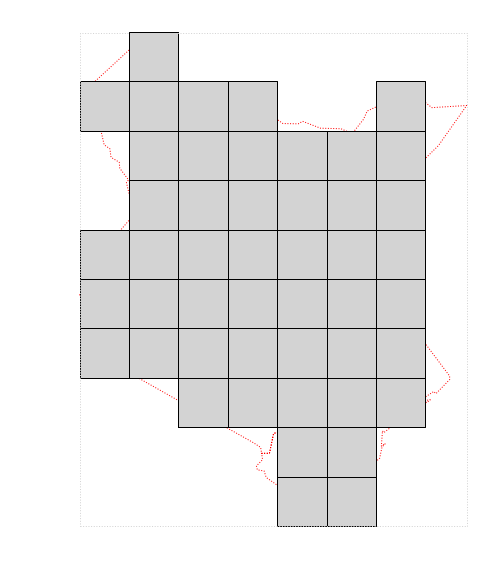

In [13]:
def run_all(seed_loc):
    start_point = seed_loc
    print('Seed location: {}'.format(start_point))
    tile_list = []
    
    outline_poly, outline_gpd = dissolve_features(admin_polys)
    
    map_extent_coords, map_extent_poly, map_extent_gdf = build_extent_polygon(admin_polys)
    updated_extent = copy.deepcopy(map_extent_coords)
    
    tile_size = calculate_tile_size(map_extent_coords)
    
    i=0
    not_enough_rows = True
    while not_enough_rows:
        try: seed_idx
        except: seed_idx = 1
        seed_idx += 100
        seed, centroid, seed_coords, seed_idx = seed_box(bb=updated_extent, size=tile_size, idx=seed_idx, corner=start_point)
        not_enough_rows = map_extent_poly.contains(centroid)
        
        if not_enough_rows:
            tiles = build_row(seed, map_extent_poly, outline_poly, seed_idx, corner=start_point)
            if tile_center_in_feature(outline_poly, centroid): # If the seed tile centroid is in polygons
                tiles += [seed]
                
            tile_list += tiles
            updated_extent = reset_seed_corner(seed_coords, updated_extent,  corner=start_point)
            i+=1
        
    # Merge tiles to one GeoDataFrame
    print('Number of cells: {}'.format(len(tile_list)))
    all_tiles = gpd.GeoDataFrame(pd.concat(tile_list, ignore_index=True, sort=False), crs=tiles[0].crs, geometry=c.geom_col)
    all_tiles = all_tiles.sort_values(by=[c.tile_id]).reset_index(drop=True)
    
    # Plot that
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.axis('off')
    #admin_polys.plot(column=c.symbology_column, cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
    outline_gpd.plot(ax=ax, facecolor="none", edgecolor='red', linestyle=':')
    all_tiles.plot(ax=ax, facecolor="lightgrey", edgecolor='black')
    map_extent_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
    
    #tile_centers = polys_to_centroids(all_tiles)
    #display_point_labels(tile_centers, c.tile_id)
        
    plt.show()
    
    return all_tiles

def main():
    #run_all('lowerleft')
    run_all('upperleft')
    #run_all('upperright')
    #run_all('lowerright')
    
#main() #Commented out for testing
all_tiles = run_all('lowerleft')


ValueError: min() arg is an empty sequence

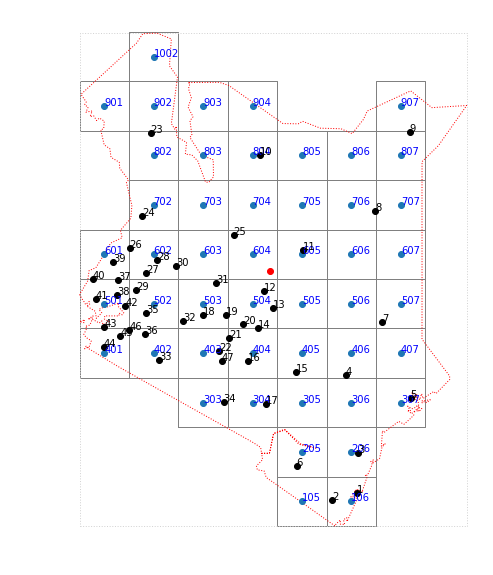

In [18]:
##### describe_gdf(all_tiles)
#describe_gdf(admin_polys)

tile_centroids = polys_to_centroids(all_tiles)
admin_centroids = polys_to_centroids(admin_polys)

# Plot that
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
#admin_polys.plot(column=c.symbology_column, cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
all_tiles.plot(ax=ax, facecolor="none", edgecolor='grey')
map_extent_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
outline_gpd.plot(ax=ax, facecolor="none", edgecolor='red', linestyle=':')
tile_centroids.plot(ax=ax)
admin_centroids.plot(ax=ax, color='black')
display_point_labels(tile_centroids, c.tile_id, 10, 'blue')
display_point_labels(admin_centroids, c.admin_id, 10, 'black')

outline_centroid_gpd = polys_to_centroids(outline_gpd)
outline_centroid_gpd.plot(ax=ax, color='red')





def calc_dist_tile_to_admins(tile_centers, admin_centers):
    distances = {}
    for idx1, tile_row in tile_centers.iterrows():
        tile_pt = tile_row[c.geom_col]
        tile_idx = tile_row[c.tile_id]
        distances[tile_idx] = {}
        
        for idx2, admin_row in admin_centers.iterrows():
            admin_pt = admin_row[c.geom_col]
            admin_idx = admin_row[c.admin_id]
            distance = tile_pt.distance(admin_pt)
            #print(distance)
            
            distances[tile_idx][admin_idx] = distance 

    return distances
    
def add_field_dist_to_outline_centroid(tile_centers, centroid):
    distances = {}
    centroid_pt = centroid[c.geom_col][1] #Get Shapely point geom from geodataframe

    for idx, tile_row in tile_centers.iterrows():
        tile_pt = tile_row[c.geom_col]
        tile_idx = tile_row[c.tile_id]
        distance = tile_pt.distance(centroid_pt)
        #print('{}  {}  {}'.format(idx, tile_row[c.tile_id], distance))
        distances[tile_idx] = distance
    distances_dict = dict(sorted(distances.items(), key=operator.itemgetter(1), reverse=True))
    distances_df = pd.DataFrame(list(distances_dict.items()), columns=[c.tile_id, 'dist_to_centroid'])
    distances_df['join_admin_order'] = distances_df.index
    tile_centers = tile_centers.join(distances_df.set_index(c.tile_id), on=c.tile_id).sort_values(by=['join_admin_order']).reset_index(drop=True)

    return tile_centers

def assign_min_of_mins(distance_dict, tiles):
    closest_admin = {}
    remove_admin_keys = []
    for tile_id, v in distance_dict.items():
        for remove_k in remove_admin_keys:
            v.pop(remove_k, None)
        admin_key_min = min(v, key=v.get)
        remove_admin_keys.append(admin_key_min)
        #print('Tile: {}  MIN Key: {}  dist: {}'.format(tile_id, admin_key_min, v[admin_key_min]))
        closest_admin[tile_id] = admin_key_min
    
    closest_admin_df = pd.DataFrame(list(closest_admin.items()), columns=[c.tile_id, 'matched_CID'])
    tiles = tiles.join(closest_admin_df.set_index(c.tile_id), on=c.tile_id)
    
    return tiles
        
tile_centroids = add_field_dist_to_outline_centroid(tile_centroids, outline_centroid_gpd)
tile_to_admin_dist_dict = calc_dist_tile_to_admins(tile_centroids, admin_centroids)
all_tiles = assign_min_of_mins(tile_to_admin_dist_dict, all_tiles)

#pprint_dict(closest_admin_dict)

all_tiles

plt.show()